<a href="https://colab.research.google.com/github/merttekdemir/AdvBert/blob/main/Adv_GAN_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The modern world is filled with an incredible abundance of text data, however much of this data is unlabled for any practical text classification purpose. With the advent of transformers and the subsequent BERT model by Devlin et al. in 2018 large strides were taken towards making this wide repository of unlabeled data more accessible for machine learning tasks.

The BERT model comes in two sizes, "base" and "large", and the models consist of 110 million parameters and 340 million parameters respectively and have been trained on massive corpora. These massive models therefore admit a strong pretrained general language understanding that allow them to be fine-tuned to downstream tasks very successfully with relatively little labeled data. Typically for class sizes less than 10, datasets on the order of 10.000 labeled examples are sufficient, possibly even on the order of 1.000 depending on the task.

Due to the cost of curating labeled text datasets and the performance of the BERT model compared to its predecessors this represents a monumental step forward in democratizing text classification tasks. Nevertheless, for niche tasks, prototyping or small research/enterprise endevors labeled datasets on the order of thousands or tens of thousands may still be prohibitively expensive.

One recent proposed solution to reduce the labeled example burden further has been the use of an adversarial and semi-supervised fine tuning procedure through GAN networks, Croce et al in 2020. This method allows to augment the existing labelled dataset both with unlabelled data as well as "fake" generated data from the Generator network during triaining. It was shown by the authors to significantly outperform the Bert model on fintuning tasks where only a handful of labeled examples are provided, typically less than 1000. However, the performance of this model quickly converges to that of the typical Bert model as the percentage of annotated examples present in the dataset grows, typically converging in performance as the annotated examples approach 10-20% of the dataset.

One alternative adversarial and semi-supervised solution that may potentially achieve a similar affect is that of adversarial training and virtual adversarial training for text classificaiton, proposed originally for LSTMs by Miyato et al in 2017. Although originally intended to regularize loss functions and not for low-data schemes, this technique also augments the existing dataset to adversarially fine tune a model and can work both in the supervised and unsupervised setting. It thus exhibits obvious parallels to the semi-supervised GAN technique. Further, although it achieved state of the art performance on its original release, to my knowledge the technique has not been applied to transformer based models yet and remains largely unexplored. One reason for this may be the subsequent publication of the BERT model which rendered LSTM's largely outdated and spurred a new line of research in the NLP field.

Beyond the parallels to the proven SS-GAN technique, adversarial/generative adversarial learning may provide strong synergies with the SS-GAN technique as well. While the GAN method is applied on the classification, and therefore output side of a model, the adversarial/generative adversarial technique is applied on the embedding, and therefore input side of a model. Moreover, the two adversarial techniques can also be applied symultaneously. Thus the three techniques may combine for an end to end adversarial and semi-supervised text classification technique performant on low data environments.

Finally, although reasons for the convergence between the vanilla BERT and GAN-BERT models were not discussed by the original authors, the adversarial techniques act as regularizers shown to prevent overfitting and increase test accuracies on larger datasets. As such there is reason to believe a model leveraging the full suite of techniques should continue to outperform the vanilla Bert model regardless of the percent of annotated data in the dataset.

What follows below is a high level introduction to the various moving parts necessary to understand this model as well as code to run an experiment of this model on the IMDB dataset.

# Brief Introduction to BERT

BERT (Bidirectional Encoder Representations from Transformers) was relased in 2018 by Devlin at al and was touted for its strong performance across the board on the tasks in the GLUE (general language understanding evaluation) benchmarks. Although BERT can be fine tuned on several natural language tasks, the techniques in this notebook are currently only developed for classification.

BERT is built on a transformer architecture and heavily leverages the self attention mechansim. At a high level the inputs to the BERT model are successively processed through a stack of transformer layers, called the encoder. This allows BERT to learn which other words in a given input sequence to focus most on when processing.

 Moreover BERT was trained on 3.3 Billion words, allowing it to gain a strong general understanding of natural language. This is a feat that would be impossible on traditional RNNs or LSTMs due to there inability to parallelize well unlike transformers. Even with the highly parallelizable architecture BERT was trained on 64 TPUs over 4 days.

 An additional reason BERT was able to be trained on such a large dataset is  due to the unsupervised nature of BERT's training. It was trained with two particular techniques. The first is called masked language model and involves masking out a word and forcing BERT to bidirectionally use the words on either side of the masked word to predict the masked word. During training a random 15% of the words were masked out in this fashion. The second technique is called next sentence prediciton where BERT was made to predict if given a pair of sentences the second sentence follows the first. During the training 50% correct sentence pairs were mixed in with 50% random sentence pairs.

For the applications of this project it is more important that the read gain an understanding of how the fine-tuning of BERT works, as opposed to the intricacies of its architecture and training procedure.


## Finetuning BERT

Recall that the BERT model consists of an inital embedding layer followed by 12 transformer layers (in the base model). The output of this model is a [512,768] dimensional tensor that is then pooled by BERT to result in a single [512] dimensional tensor. Finetuning BERT typically refers to the practice of adding a task specific linear layer on top of the output of the pooled BERT output and training this model on some new data for a handful of epochs. This allows to take advantage of the learned representation of the BERT model and perform a sort of "feature extraction" from the text before passing it onto the task specific layer. In essence it can be thought of as a super-charged preprocessing technique before out final output layer.

In order to fine tune BERT on a specific dataset one must first format their data to match the orginial format used during BERT's pre-training. This can be done using the hugging face's tokenizer implementation. The steps it performs for a given string are briefly outlined below:

1. Inserting Special Tokens

Due to how it was trained BERT can accept as input either a single sentence or a pair of sentences. The special token [SEP] is used to differentiate sentences and is required even if a single sentence is provided. Further, the token [CLS] is used at the start of a given text and is specific to classification tasks.

2. Tokenization

BERT tokenizes raw text using a WordPiece model. This is a model that greedily creates a fixed-size vocabulary of individial charecters, subwords and words that best represent the language. BERT is limited to a vocabulary of 30.000 words and as such the WordPiece model generates a unique token corresponding to each charecter in the English language and the 30.000 most common words and subwords it encountered.

To tokenize a word the model first checks if the word is in the vocabulary, if it is not it tries to break the word into the largest possible subwords contained in the vocabulary. As a last resort it will decompose the words into individual charecters. A consqeuence is that every word can be broken down and BERT does not need a special token to represent out of vocabulary words. A representation of the embedding of a decomposed word can be recovered by averaging the embedding of its decomposed components.

for instance if the word "running" is not found in the vocabulary it may be decomposed as ["run", "n" "##ing"] where the ## convention is used to represent subwords not occuring at the front of a word.

3. Token Type IDs

Because BERT was trained on sentence pairs it expects that it may recieve a sentence pair as input. A token type id is a binary tensor indicating which tokens belong to the first sentence and which belong to the second sentence. Because in this application only single sentences will be provided this tensor is a made up entirely of ones.

4. Attention Masks

BERT admits a maximum sequence length of 512 tokens. However not every input will consist of 512 sequences that need to be encoded. As a result BERT expects an additional input called the attention mask which is a binary tensory indicating which tokens needs to be attended to and which do not, for instance if they are just a result of padding.

Given the above inputs one can now perform a forward pass on the BERT model. The input data will first pass through the bert embedding layer. This embedding layer combines word (token) embeddings, positional embeddings and token type embeddings into one tensor of shape [512, 768] where 512 is the sequence length and 768 is the embedding dimension. Following a normalization this output is then passed through the 12 transformer blocks of BERT. The resultant [512,768] tensor is pooled by passing through a dense layer and results in a tensor of dimension [512]. This output can then be passed through additional task specific layers, typically linear layers for classification.

Note that the outputs from the BERT transformer layer are often also called Embeddings. This is because they learn contextual representations of the data and are useful for many traditional use cases like word similarities. However to avoid confusion in the following sections embeddings are used to refer to the output of the Bert embedding layer as this is paticularly important for implementing the adversarial loss techniques.

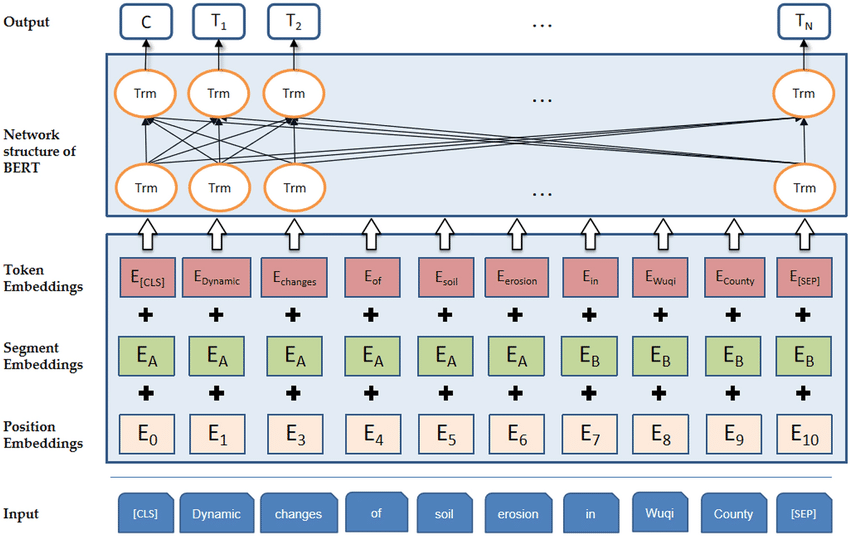

# GAN-BERT

GAN-BERT was introduced by Croce et al. in 2020 and involves fintuning BERT where the classification head of the the network is the discriminator in a semi-supervised GAN game. GANs as described in Goodfellow et al. 2014 involve a Generator network that is trained to produce samples resembling the underlying data's distribution. This process "adversarially" depends on a Discriminator which is trained to distinguish samples produced by the Generator from those present in the data. Semi-Supervised GANs are an extension of this paradigm introduced by Salimans et al. in 2016 where the discriminator also assigns a label from the possible class labels while discriminating if the input is produced from the generator. In essence the discriminator wants to correctly predict if the data belongs to any of the $K$ real classes present in the data or some $k+1$-th class representing the data produced by the generator.

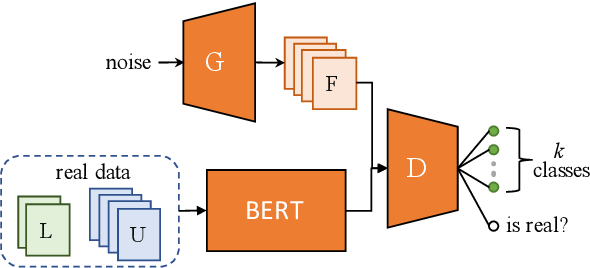

## Semi-Supervised GANs

As described above, the disciminator in the semi-supervised GAN setting is trained over a $(k+1)$ class objective where the "real" data is composed of $k$ class labels and the final class corresponds to "fake" or augmented data produced by the generator.

Formally denote by $D$ the discriminator, $G$ the generator, $p_D$ the real data distirbution and $p_G$ the generated examples. Define $p_m(\hat{y}=y | x, y=k+1)$ as the probability assigned by the model $m$ that an input $x$ belongs  to the fake class and $p_m(\hat{y}=y | x, y \in (1,\dots,k))$ as the probability assigned by the model $m$ than an input $x$ belongs to one of the real classes.

We train the discriminator to minimize $L_D = L_{D_{sup}} + L_{D_{unsup}}$ where:

$$L_{D_{sup}} = - E_{x,y \sim p_D} log[p_m(\hat{y} = y | x, y \in (1, \ldots, k))$$

$$L_{D_{unsup}} = - E_{x \sim p_D} log[1-p_m(\hat{y}=y | x, y=k+1)]\\
- E_{x \sim p_G} log[p_m(\hat{y}=y | x, y=k+1)$$

Intuitively, $L_{D_{sup}}$ measures the error in assigning the wrong class to a real example among the original $k$ categories, thus is is the traditional negative log likelihood that would be used by a classification layer. On the other hand, $L_{D_{unsup}}$ measures the error in incorrectly recognizing a real (unlabeled) input as fake as well as the not recognizing a fake example as fake. It can be thought of like a binary classification task where the discriminator attempts to predict the unlabeled inputs as either coming from the real data or the generated data.

At the same time the generator is exepected to generate samples that are similar in distribution to the real data $p_D$. The aveage example generated in a batch by $G$ should be similar to the real prototypical one. We train the generator to minimize $L_G = L_{G_{\text{feature matching}}} + L_{G_{unsup}}$ where:

$$L_{G_{\text{feature matching}}} = ||E_{x \sim p_D} f(x) - E_{x \sim p_G} f(x)||_2^2$$

$$L_{G_{unsup}} = -E_{x \sim p_G} log[1-p_m(\hat{y}=y | x, y=k+1)]$$

In the above $f(x)$ denotes the activation on an intermediate layer of the discriminator network, typically taken to be the last hidden layer. Thus, the feature matching loss implies the generator is penalized the further its representation of the data is from the real data passed through the discriminator network. The unsupervised loss instead accounts for the "labeled error" of the generator, it is penalized for every generated output that failed to trick the discriminator.

Note that the input to the generator network is a random noise vector of equal dimension to the pooled output of the Bert model, namely of dimension [512]. Following fine-tuning the generator network can be discarded and it does not contribute to inference time.

# Adversarial Learning

## Introduction

In a nutshell adversarial training is when we apply small perturbations to our machine learning model's inputs to significantly increase the loss incurred by it during training.

Interestingly many state of the art classification model's fail to correctly classify adversarially perturbed inputs, even when these perturbations are infinitesimal such that the perturbed input and original input are indistinguishable to humans.

For instance consider the following from "Explaining and Harnessing Adversarial Examples" by Goodfellow et al in 2015. In this example an infinitesimal perturbation is applied to the pixels of an image of a panda, such that to a human the presence of the perturbation is indectable. Nevertheless GoogLeNet, a state of the art network at the time, fails to classify the image correctly following the perturbation, despite having correctly classified it previously, and worse yet is highly confident in its inaccuracy.

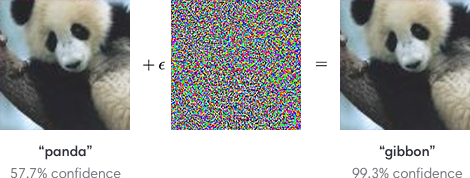

During the adversarial training process the model is trained to be more robust to such instance by learning to correctly classify these approximate worst case perturbations of the model in addition to the original inputs. As such this method can also be seen as a data augmentation scheme, as additional forward and backwards passes are peformed on the adversarially perturbed data. Moreover, these data points are curated such that they improve the internal represenation of the model and should therefore be valuable training examples.

## Supervised Adversarial Training

Supervised adversarial training, or simply adversarial training, was introduced in the in the aforementioned paper by Goodfellow et al. and is a general regularization technique for classification models. Denote by $y$ the label to a corresponding input $x$ to some classification model parameterized by a vector $\theta$. When applied to a classifier, adversarial adds the following term to the cost funciton:

$$- \log p(y | x + r_{adv}; \theta)$$ where $$r_{adv} = \underset{r, ||r|| \leq \epsilon}{\operatorname{arg min}} \log p(y | x + r_{adv}; \hat{\theta})$$


In the above $r$ is a perturbation on the input and $\hat{\theta}$ is constant set to the curent parameters of the classifier. The use of the contstant copy indicates that the backpropagation algorithm should not be used to propagate through the adversarial example construction process. In practice what this implies is that at each training step, after calculating the loss of the model, a worst case perturbation $r_{adv}$ against the current model $p(y | x; \hat{\theta})$ is found and the model parameters are updating by backpropagating on the joint unperturbed and pertubed lossses. Since the exact minimization requried for calculating $r_{adv}$ is intractable for neural networks Goodfellow et al 2015 proposed linearizing $\log p(y | x + r_{adv}; \hat{\theta})$ around x. Together with an $L_2$ norm constraint this results in:

$$r_{adv} = - \epsilon \frac{g}{||g||_2}$$ where $$g = \nabla_x \log p(y|x; \hat{\theta})$$

This perturbation can be easily calculated in neural networks by backpropagation.


## Virtual Adversarial Training

Virtual adversarial training is a regularization method very similar in sipirit to the adversarial regulatization method seen above. It was originally introduced by Miyato et al. in 2016 to promote smootheness in model distributions. It relies on a notion of local distributional smoothness around an input datapoint $x$, which is defined as the Kulback-Leibler divergence based robustness of the model distribution against local perturbations around the given input. The additional cost introduced to the classifiers cost function by virtual adversarial training is as follows:

$$KL[p( \cdot | x; \hat{\theta}) || p( \cdot | x+r_{v-adv}; \hat{\theta})]$$
where
$$ r_{v-adv} = \underset{r, ||r|| \leq \epsilon}{\operatorname{arg max}} KL[p( \cdot | x; \hat{\theta}) || p( \cdot | x+r; \hat{\theta})]$$

By minimizing the joint loss of the classifier together with the vritual adversarial penalty the claissifer is trained to admit smoother probability distributions. This can in turn be considered as making the classifier $p( y | x; \hat{\theta})$ robust to pertubations in directions it is most sensitive.

Further, note that unlike in the adversarial trianing, the label $y$ is not necessary for calculating the penalty in virtual adversarial training, thus allowing it to be used in a semi-supervised setting.

As with adversarial training this method can be easily applied in neural networks through back propagation.

## Applications to text data

A first complication in applying adversarial perturbations to text data is that the method relies on making small modifications to very many real-valued
inputs. In the case of text data inputs are typically discrete and low dimensional vectors. Because the discrete inputs do not admit infinitesimal perturbation when applying adversarial learning to text data we talk about perturbation on continuous word embeddings instead of discrete word inputs.

Further, while adversarial training can be seen as a regularization technique, it is also commonly done to protect networks from outside threats. However, in the case of text classification since the perturbations will be applied to the word embeddings rather than the direct text input, and since an adversary will be very unlikely to have access to these embeddings, adversarial training in this setting is intended predominately as a regularization technique.

As a first introduction to the applications to text data consider the traditional word embedding setting. Denote a sequence of T words as $[w^{(t)} | t = 1, \ldots, T]$. To transform a discrete word input to a continuous vector define the word embedding matrix $V \in \mathbb{R}^{(K+S) \times D}$ Where $K$ is the number of words in the vocabulary, and each row $v_i$ corresponds to the word embedding of the $i$-th word. Note that the additional S tokens represent the embeddings of any special tokens. For instace in the BERT model there are two such tokens:  "SEP" and "CLS". At each time step $t$ the input to the model is the discrete word $w^{(t)}$ which is trasformed through $V$ into the corresponding word embedding. Additionally, since the embedding matrix $V$ is learned, to prevent the model learning to make the perturbations insignificant by learning embeddings with large norm the embeddings are replaced with normalized embeddings:

$$\bar{v_i} = \frac{v_i - E(v)}{\sqrt{Var(v)}}$$

Where $$E(v) = \sum_{j=1}^K f_j v_j, \quad Var(v) = \sum_{j=1}^K f_j (v_j - E(v))^2$$

where $f_i$ is the frequency of the i-th word, calculated within all trianing examples.

Denote by $s$ a concatenation of a sequence of such normalized word embedding vectors $[\bar{v}^{(1)}, \bar{v}^{(2)}, \ldots, \bar{v}^{(T)}]$. The model conditional probability of the corresponding label $y$ given $s$ is then $p(y|s;\theta)$ for the current model parameters $\theta$. We then define the adversarial perturbation $r_{adv}$ on s as:

$$r_{adv} = - \epsilon \frac{g}{||g||_2}$$ where $$g = \nabla_s \log p(y|s; \hat{\theta})$$

The adversarial loss penalty thus becomes:

$$L_{adv}(\theta) = - \frac{1}{N} \sum_{n=1}^N \log p(y_n | s_n +r_{adv, n}; θ)$$

Where $N$ is the number of labelled examples. This loss is typically added to the negative log-likelihood and minimized through backpropagation.

In the virtual adversarial case instead the perturbation will be calcualted as:

$$r_{v-adv} = - \epsilon \frac{g}{||g||_2}$$ where $$g = \nabla_{s+d} KL[p( \cdot | s; \hat{\theta}) || p( \cdot | s+d; \hat{\theta})]$$

Where $d$ is a $TD$-dimesnional small random vector. Further details can be seen in Miyato et al. 2016 but this method corresponds to iteratively axpproximating the labelled perturbation in the adversarial method through a second order taylor expansion and the power itertion method. Miyato et al. show that this approximation improves monotonically with each iteration but typically a single iterative step is sufficient for good performance. Because of the parallels in leveraging a noise vector and parallels between the loss of the Generator network and the loss used to compute the perturbation we refer to the technique as generative adversarial training or gadv moving forwards.


## Applications to BERT Embeddings

The BERT model in its base case is known for having 12 transformer layers. However before passing data to these layers the input to the BERT model are passed through a BERT embedding layer. This embedding layer combines word embeddings, positional embeddings and token type embeddings into one tensor. This is inherently different from the embeddings used in the LSTM model both because they are no longer purely word embeddings and because they result in context dependent embeddings.

Nevertheless the application of the technique is analogous. For each of the three types of inputs the model expects a discrete sequence as before. Each of these have a seperate matrix resulting in a seperate emedding for each sequence. They are then summed and normalized as seen in the explanation above resulting in a single tensor of dimension [512, 768] where 512 is the maximum sequence length of the BERT model and 768 is the embedding dimension. The perturbations are then applies to the output of the Bert embedding layer before moving forward through the 12 transformer layers.

# Install Necessary Libraries

In [ ]:
!pip install -q pytorch-lightning wandb
!pip install --q torchmetrics
!pip install --q Datasets
!pip install --q transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.7/206.7 kB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.1 MB/s eta 

In [ ]:
import wandb
import torch
import itertools
import numpy as np
import torchmetrics
import pandas as pd
import seaborn as sns
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F

from google.colab import drive
from datasets import load_dataset
from pytorch_lightning.loggers import WandbLogger
from transformers.models.bert import modeling_bert
from pytorch_lightning.callbacks import ModelCheckpoint
from typing import List, Optional, Tuple, Union, Dict, Any
from torch.utils.data import Dataset, DataLoader, RandomSampler
from transformers import DataCollatorWithPadding, BertTokenizer, DataCollatorWithPadding, AutoConfig



# Define torch lightning data module and torch dataset classes

Like any Torch project the Dataset class must be defined which implements the logic for calculating the length of the dataset and retrieving items from the dataset.

In addition to this a torch lightning data module class is defined. This handles all the logic for loading data from off-disk or on-disk, preprocessing the data and staging it to be used with the torch lightning trainer.

In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, df):
        """
        Initalizer for the IMDBDataset class. This class takes as input a
        pandas dataframe and handles the logic for creating a torch-like
        dataset.

        ---parameters---
        df: pandas.DataFrame containing the preprocessed imdb data.
        """
        self.df = df
        self.df["attention_mask"] = self.df["attention_mask"].apply(lambda x: x.astype("int64"))
        self.df["token_type_ids"] = self.df["token_type_ids"].apply(lambda x: x.astype("int64"))
        self.df["input_ids"] = self.df["input_ids"].apply(lambda x: x.astype("int64"))

    def __len__(self):
        """
        Returns the length of the Dataset as the length of the underlying
        pandas dataframe.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Handles getting data from the dataset through indexing by
        returning a dictionary of the underlying pandas dataframe
        at the specfied index.

        ---parameters---
        idx: interger value representing the row index of the dataset

        ---output---
        A dictionary containing the label, input_ids, token_type_ids,
        attention_mask and label_mask of the pandas dataframe at the
        specified index. These are the columns necessary for running
        the model.
        """
        return {"labels" : self.df['label'][idx],
                "input_ids" : self.df['input_ids'][idx],
                "token_type_ids" : self.df['token_type_ids'][idx],
                "attention_mask" : self.df['attention_mask'][idx],
                "label_mask" : self.df['label_mask'][idx]}

class IMDBDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_frac=1.0, annotation_frac=1.0, balance_labeled_examples=True, max_seq_length=64):
        """
        Initalilzer for the IMDBDataModule class. contains the logic for
        downloading to disk, preprocessing, loading from disk and staging
        the imdb dataset.

        ---parameters---
        batch_size: integer value representing the size to batch the original data

        data_frac: float value representing what fraction of the toal IMDB
        dataset to use in the training stage.

        annotation_frac: float value representing what fraction of the total
        IMDB data should be labeled.

        balance_labeled_examples: Boolean value specifying if upsampling should be
        applied to the labeled examples. Aims to prevent having batches of purely
        unlabeled examples as specified in https://aclanthology.org/2020.acl-main.191

        max_seq_length: Integer value between [1, 512] specifying the maximum sequence
        length to apply when tokenizing the text data.
        """
        super().__init__()
        self.max_seq_length = max_seq_length
        self.batch_size = batch_size
        self.data_frac = data_frac
        self.annotation_frac = annotation_frac
        self.balance_labeled_examples = balance_labeled_examples
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #automodel

    def preprocess_function(self, examples):
        """
        Applies the hugging faces tokenizer's encode plus function on a given
        text input.

        ---parameters---
        examples: A row from a dataset or dictionary like object containing the
        column "text" with text input.
        """
        return self.tokenizer.encode_plus(text=examples["text"],
                                    add_special_tokens=True, #Adds [CLS] and [SEP] tokens
                                    truncation=True, #Truncates to maximum acceptable input length (or max_len argument if provided)
                                    padding='max_length', #pads to max_length argument
                                    max_length=self.max_seq_length,
                                    #return_tensor='pt', #return a pytorch array, not compatible with arrowdataset
                                    return_token_type_ids=True,
                                    return_attention_mask=True)

    def download_data(self, dataset, path, split, output=True):
        """
        Function for downloading onto disk in pickle format the raw IMDB data
        from the huggingfaces repository.

        ---parameters---
        dataset: string value specifying the path on the huggingfaces repository
        to the dataset to be downloaded. In this case "imdb".

        path: string value specifying where on disk to save the pandas dataframe.

        split: string value specifying which split of the imdb dataset to
        download. either "train", "test" or "unsupervised".

        output: boolean value indicating if the function should return the
        downloaded data.

        ---output---
        pandas.Dataframe containing the downloaded IMDB data if output parameter
        set to True.
        """
        #split may be either train test unsupervised
        df = load_dataset(dataset, split=split)
        df = df.map(self.preprocess_function) #apply the preprocess function
        df = df.to_pandas() #convert the arrow dataset to a pandas dataframe
        df.to_pickle(path) #pickle the pandas dataframe on disk

        #according to the split assign the dataframe the corresponding variable
        if split == "train":
            self.train = df
        if split =="test":
            self.test = df
        if split == "unsupervised":
            self.unsupervised = df

        if output:
            return df

        return

    def load_pickle_data(self, split, path=None, df=None):
        """
        Function handling loading a pickled pandas dataframe in pickle from
        disk or alternatively a pandas dataframe variable and staging it.

        ---parameters---
        split: string value specifying which split of the imdb dataset is
        loaded. either "train", "test" or "unsupervised".

        path: string value specifying where on disk to load the pickled pandas
        dataframe.
        """
        #from disk or variable
        if path is not None and df is None:
          df = pd.read_pickle(path)
        elif path is None and df is not None:
          df = df
        else:
          raise Exception("Must provide either a path to a pandas df or directly a pandas df")

        #how to stage the data
        if split == "train":
            self.train = df
        if split =="test":
            self.test = df
        if split == "unsupervised":
            self.unsupervised = df

    def prepare_data(self, split):
        """
        Function handling how to prepare the preprocessed data already staged
        in the class to be used for training or testing/validation.
        """

        #check if the data is staged
        if not hasattr(self, split):
            raise Exception("Plese load or download the data for this split first")

        #logic for handling train data
        if split == "train":

            #if we are using less than all of the data take a random subsample
            if self.data_frac < 1.0:
                self.train = self.train.sample(frac=self.data_frac).reset_index(drop=True)

            #if not all of the train data should be labeled...
            if self.annotation_frac < 1.0:
                #Split the dataset into two according to the annotation frac size
                annotated = self.train.sample(frac=self.annotation_frac)
                unannotated = self.train.drop(annotated.index)

                #apply a label mask to each split, this will be used to tell the
                #model if a labelled loss should be calculated for this example
                #when training downstream
                annotated['label_mask'] = 1
                unannotated['label_mask'] = 0

                #If we want to upsample the labeled examples following the split
                if self.balance_labeled_examples == True:
                    #Calculate how many times to replicate each labeled example
                    balance = max(1, int(np.log2(1/self.annotation_frac)))
                    #concatenate the annotated data balance times together
                    #with the unannotated data and shuffle
                    self.train = pd.concat([annotated for i in range(balance)]+[unannotated])
                    self.train = self.train.sample(frac=1).reset_index(drop=True)

                else:
                  self.train = pd.concat([annotated,unannotated]).reset_index(drop=True)
            else:
                self.train['label_mask'] = 1

        #For splits other than training we just assign the relevant label mask
        if split =="test":
            self.test['label_mask'] = 1

        if split == "unsupervised":
            #dummy label will not be used for loss calculations
            self.unsupervised['label'] = 0
            self.unsupervised['label_mask'] = 0

    def setup(self, stage):
        """
        Function that transforms the staged data into torch dataset objects
        according the the training stage

        ---parameters---
        stage: string value, either "fit", "test", "predict", indicating what
        stage of training the data should be prepared for.
        """
        if stage=="fit":
            self.train = IMDBDataset(self.train)
            self.val = IMDBDataset(self.test)

        if stage=="test":
            self.test = IMDBDataset(self.test)

        if stage=="predict":
            self.predict = IMDBDataset(self.test)

    def train_dataloader(self):
        """
        Returns the torch data loader for the training set with
        random sampling applied.
        """
        sampler = RandomSampler(self.train)
        return DataLoader(self.train, batch_size=self.batch_size, sampler=sampler)

    def val_dataloader(self):
        """
        Returns the torch data loader for the validation set with
        random sampling applied.
        """
        return DataLoader(self.val, batch_size=self.batch_size)

    def test_dataloader(self):
        """
        Returns the torch data loader for the test set with
        random sampling applied.
        """
        return DataLoader(self.test, batch_size=self.batch_size)

    def predict_dataloader(self):
        """
        Returns the torch data loader for the prediction set with
        random sampling applied.
        """
        return DataLoader(self.predict, batch_size=self.batch_size)


# Define modified Bert Model able to apply perturbations to the embedding layer output

The cell below subclasses the original BertModel from the huggingfaces repository and makes one change only. The subclassed model "AdversarialBertModel" allows to take an additional input in the forward pass called "perturbation". This is a tensor value of equal dimensions to the bert embedding layer output containing the embedding perturbations calculated at the training step. This perturbation value, if provided, is added to the output of the embedding layer. If no perturbation value is provided the AdversarialBertModel's forward pass is identical to the vanilla BertModel

In [ ]:
class AdversarialBertModel(modeling_bert.BertPreTrainedModel):
    def __init__(self, config, add_pooling_layer=True):
        super().__init__(config)
        self.config = config

        self.embeddings = modeling_bert.BertEmbeddings(config)
        self.encoder = modeling_bert.BertEncoder(config)

        self.pooler = modeling_bert.BertPooler(config) if add_pooling_layer else None

        # Initialize weights and apply final processing
        self.post_init()

    def get_input_embeddings(self):
        return self.embeddings.word_embeddings

    def set_input_embeddings(self, value):
        self.embeddings.word_embeddings = value

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        perturbation: Optional[torch.Tensor] = None, #adversarial perturbation applied to embedding output of given input
        encoder_hidden_states: Optional[torch.Tensor] = None,
        encoder_attention_mask: Optional[torch.Tensor] = None,
        past_key_values: Optional[List[torch.FloatTensor]] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.Tensor], modeling_bert.BaseModelOutputWithPoolingAndCrossAttentions]:
        r"""
        encoder_hidden_states  (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
            Sequence of hidden-states at the output of the last layer of the encoder. Used in the cross-attention if
            the model is configured as a decoder.
        encoder_attention_mask (`torch.FloatTensor` of shape `(batch_size, sequence_length)`, *optional*):
            Mask to avoid performing attention on the padding token indices of the encoder input. This mask is used in
            the cross-attention if the model is configured as a decoder. Mask values selected in `[0, 1]`:
            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.
        past_key_values (`tuple(tuple(torch.FloatTensor))` of length `config.n_layers` with each tuple having 4 tensors of shape `(batch_size, num_heads, sequence_length - 1, embed_size_per_head)`):
            Contains precomputed key and value hidden states of the attention blocks. Can be used to speed up decoding.
            If `past_key_values` are used, the user can optionally input only the last `decoder_input_ids` (those that
            don't have their past key value states given to this model) of shape `(batch_size, 1)` instead of all
            `decoder_input_ids` of shape `(batch_size, sequence_length)`.
        use_cache (`bool`, *optional*):
            If set to `True`, `past_key_values` key value states are returned and can be used to speed up decoding (see
            `past_key_values`).
        """

        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if self.config.is_decoder:
            use_cache = use_cache if use_cache is not None else self.config.use_cache
        else:
            use_cache = False

        if input_ids is not None and inputs_embeds is not None:
            raise ValueError("You cannot specify both input_ids and inputs_embeds at the same time")
        elif input_ids is not None:
            input_shape = input_ids.size()
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            raise ValueError("You have to specify either input_ids or inputs_embeds")

        batch_size, seq_length = input_shape
        device = input_ids.device if input_ids is not None else inputs_embeds.device

        # past_key_values_length
        past_key_values_length = past_key_values[0][0].shape[2] if past_key_values is not None else 0

        if attention_mask is None:
            attention_mask = torch.ones(((batch_size, seq_length + past_key_values_length)), device=device)

        if token_type_ids is None:
            if hasattr(self.embeddings, "token_type_ids"):
                buffered_token_type_ids = self.embeddings.token_type_ids[:, :seq_length]
                buffered_token_type_ids_expanded = buffered_token_type_ids.expand(batch_size, seq_length)
                token_type_ids = buffered_token_type_ids_expanded
            else:
                token_type_ids = torch.zeros(input_shape, dtype=torch.long, device=device)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask: torch.Tensor = self.get_extended_attention_mask(attention_mask, input_shape)#, dtype=torch.float32)

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.config.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=device)
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        #If the perturbation value has been provided the embedding output value
        #is summed with the perturbation values
        #if it is not provided this is equivalent to the vanilla BertModel
        if perturbation is not None:
            embedding_output = self.embeddings(
                                input_ids=input_ids,
                                position_ids=position_ids,
                                token_type_ids=token_type_ids,
                                inputs_embeds=inputs_embeds,
                                past_key_values_length=past_key_values_length,
                            ) + perturbation

        else:
            embedding_output = self.embeddings(
              input_ids=input_ids,
              position_ids=position_ids,
              token_type_ids=token_type_ids,
              inputs_embeds=inputs_embeds,
              past_key_values_length=past_key_values_length,
          )

        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None

        if not return_dict:
            return (sequence_output, pooled_output) + encoder_outputs[1:]

        return modeling_bert.BaseModelOutputWithPoolingAndCrossAttentions(
            last_hidden_state=sequence_output,
            pooler_output=pooled_output,
            past_key_values=encoder_outputs.past_key_values,
            hidden_states=encoder_outputs.hidden_states,
            attentions=encoder_outputs.attentions,
            cross_attentions=encoder_outputs.cross_attentions,
        )


# Generator

In the cell below the Generator model is defined. This is a tradional MLP which will be used in training to produce representations matching that of the pooled BertModel/AdversarialBertModel outputs.

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], relu_slope=0.2, dropout_rate=0.1):
        """
        Initalilzer for the Generator model. It is a feed forward network taking
        as input a random noise vector and producing as output a tensor trained
        to represent the output of the bert pooling layer.

        ---parameters---
        noise_size: Integer value representing the dimension of the random noise
        vector to be passed as input to the generator

        output_size: Interger value representing the dimension of the output to
        be prodcued from the final linear layer.

        hidden_sizes: An iterable of integer values representing the output
        dimension of each intermediate feed forward layer.

        relu_slope: Float value for the slope coefficient in the relu actviation
        function

        dropout_rate: Float value representing the fraction of neurons to
        deactivate in across each feedforward layer during training

        ---output---
        torch neural network module
        """
        super(Generator, self).__init__()

        self.noise_size = noise_size

        layers = []

        hidden_sizes = [noise_size] + hidden_sizes #Append noise_size as first size

        #Create as many linear layers as in hidden_sizes
        #Apply the RELu activation and dropout to each
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]),
                           nn.LeakyReLU(relu_slope, inplace=True),
                           nn.Dropout(dropout_rate)])

        #Add the output final linear layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))

        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        """
        Forward pass of the model simply takes as input the random noise vector
        and applies the MLP network.

        ---parameters---
        noise: A (gaussian) random tensor of shape noise_size

        ---output---
        A tensor of size output_size
        """
        output_representation = self.layers(noise)
        return output_representation

# Define discriminator model

In the cell below the Discrminator model is defined. This is a tradional MLP classification network which will be used in training to classify both between the oringal labels and if the data is produced by the generator.

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, relu_slope=0.2, dropout_rate=0.1):
        """
        Initalizer for the discriminator network. It takes as input a tensor of
        size input_size which is either the output of the Bert pooling layer or
        the Generator network and tries to classify it according to num_labels+1
        classes, where the +1 class corresponds to predicting the data was
        produced by the generator.

        ---parameters---
        input_size: integer value representing the size of the tensor produced
        by the Bert pooling layer/Generator network.

        hidden_sizes: An iterable of integer values representing the output
        dimension of each intermediate feed forward layer.
        """
        super(Discriminator, self).__init__()

        self.num_labels = num_labels

        self.input_dropout = nn.Dropout(dropout_rate)

        layers = []

        hidden_sizes = [input_size] + hidden_sizes #add input_size as first size

        #Create as many linear layers as in hidden_sizes
        #Apply the RELu activation and dropout to each
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]),
                           nn.LeakyReLU(relu_slope, inplace=True),
                           nn.Dropout(dropout_rate)])

        #Initallize also a softmax layer and final hidden layer
        self.layers = nn.Sequential(*layers)
        self.logit = nn.Linear(hidden_sizes[-1], num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_representation):
        """
        The forward call for the discriminator network. Given the input
        it applies the linear layers, a final output linear layer and a
        softmax layer.

        ---parameters---
        input_representation: tensor of size input_size. It is the output
        of either the Bert pooling layer or the Generator network.

        ---output---
        A tuple containing the output of the last hidden layer, the output of
        the final linear layer (output layer) and the result of a softmax layer
        applied on this output layer. All three are used at various stages in
        the training loss calculation.
        """
        input_representation = self.input_dropout(input_representation)
        last_representation = self.layers(input_representation)
        logits = self.logit(last_representation)
        probs = self.softmax(logits)
        return (last_representation, logits, probs)

# Define torch lightning module built on top of the AdvBert, Generator and Discriminator model

In [ ]:
class AdvGanBertModel(pl.LightningModule):
    def __init__(self,
                 pretrained_bert_model_path='bert-base-uncased',
                 num_labels=2,
                 num_hidden_layers_disc=1,
                 num_hidden_layers_gen=1,
                 noise_size=100,
                 out_dropout_rate=0.2,
                 learning_rate_discriminator=5e-5,
                 learning_rate_generator=5e-5,
                 use_generator=True,
                 adv_penalty=False,
                 gadv_penalty=False,
                 pi=1,
                 adv_epsilon=0.02,
                 gadv_epsilon=0.02,
                 adv_coef=1,
                 gadv_coef=1):

        """
        A torch lightning module combining the AdvBertModel, the Generator
        network and the Discriminator network. It contains the logic and
        necessary hepler functions for training the network.

        ---parameters---
        pretrained_bert_model_path: a string indicating which bert model to
        initalize the AdvBert model from among the ones on the hugging faces
        repsoitory.

        num_labels: An integer reprsenting the number of labels for initalizing
        the Discriminator network.

        num_hidden_layers_disc: An integer reprsenting the number of hidden
        layers to have in the Disciminator network.

        num_hidden_layers_gen: An integer reprsenting the number of hidden
        layers to have in the Generator network.

        noise_size: An integer reprsenting the size of the input tensor passed
        to the Generator network.

        out_dropout_rate: A float value reperesenting the dropout rate that
        will be applied to all intermediate layers of the Generator and
        Discriminator networks during training.

        learning_rate_discriminator: A float value representing the learning
        rate in the Discriminator network's optimizer.

        learning_rate_generator: A float value representing the learning
        rate in the Generator network's optimizer.

        use_generator: A Boolelan hyperparameter indicating if the Generator
        network should be used for semi-supervised learning during training

        adv_penalty: A Boolean hyperparameter indicating if the adversarial.
        training regularizer should be applied to the loss.

        gadv_penalty: A Boolean hyperparameter indicating if the generative
        adversarial training regularizer should be applied to the loss.

        pi: An integer hyperparameter indicating how many power iterations
        should be applied when estimating the perturbation for the generative
        adversarial training regularizer.

        adv_epsilon: A float hyperparameter representing the bound placed on
        the perturbation applied for the adversarial training regularizer.

        gadv_epsilon: A float hyperparameter representing the bound placed on
        the perturbation applied for the generatiev adversarial training
        regularizer.

        adv_coef: A float hyperparameter representing the coefficient with
        which the adversarial training penalty should be added to the
        Discriminator network's loss

        gadv_coef: A float hyperparameter representing the coefficient with
        which the generative adversarial training penalty should be added to
        the Discriminator network's loss

        """

        super(AdvGanBertModel, self).__init__()

        #load the AdvBert model from the hugging faces repository
        self.bert = AdversarialBertModel.from_pretrained(pretrained_model_name_or_path=pretrained_bert_model_path)

        #load the config relating to the loaded bert model
        config = AutoConfig.from_pretrained(pretrained_bert_model_path)
        #this value represents the size of the tensor produced from the bert
        #pooling layer, and is thus also the size outputted by the Generator and
        #the size the Discriminator network expects as input
        self.hidden_size = int(config.hidden_size)

        #the hidden size is used in each intermediate layer
        hidden_levels_gen = [self.hidden_size for i in range(0, num_hidden_layers_gen)]
        hidden_levels_disc = [self.hidden_size for i in range(0, num_hidden_layers_disc)]

        self.use_generator = use_generator

        #initalize the generator
        self.generator = Generator(noise_size=noise_size, output_size=self.hidden_size, hidden_sizes=hidden_levels_gen, dropout_rate=out_dropout_rate)

        #initalize the disciminator
        self.discriminator = Discriminator(input_size=self.hidden_size, hidden_sizes=hidden_levels_disc, num_labels=num_labels, dropout_rate=out_dropout_rate)

        self.learning_rate_discriminator = learning_rate_discriminator
        self.learning_rate_generator = learning_rate_generator

        self.adv_penalty = adv_penalty
        self.adv_coef = adv_coef
        self.adv_epsilon = adv_epsilon

        self.gadv_penalty = gadv_penalty
        self.gadv_coef = gadv_coef
        self.gadv_epsilon = gadv_epsilon
        self.pi = pi

        if adv_penalty == True:
            if adv_coef == None:
              raise Exception("If using an adversarial penalty you must provide a weight coefficient")
            if adv_epsilon == None:
              raise Exception("If using an adversarial penalty you must provide a normalization bound")

        if gadv_penalty == True:
            if gadv_coef == None:
              raise Exception("If using a generative adversarial penalty you must provide a weight coefficient")
            if gadv_epsilon == None:
              raise Exception("If using a generative adversarial penalty you must provide a normalization bound")
            if pi == None:
              raise Exception("If using a generative adversarial penalty you must provide a power iteration value")

        #activated manual optimization telling torch lightning that the logic
        #for the optimizer step will be included in the trianing step
        #this is necessary to successfully apply the GAN game
        self.automatic_optimization = False

        #Accuracy tracking for logs
        if num_labels > 2:
            self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.discriminator.num_labels)
            self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.discriminator.num_labels)
            self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=self.discriminator.num_labels)

        elif num_labels == 2:
            self.train_acc = torchmetrics.Accuracy(task="binary", num_classes=self.discriminator.num_labels)
            self.val_acc = torchmetrics.Accuracy(task="binary", num_classes=self.discriminator.num_labels)
            self.test_acc = torchmetrics.Accuracy(task="binary", num_classes=self.discriminator.num_labels)

        #logging hyperparameters
        self.save_hyperparameters()

    def compute_masked_cross_entropy_loss(self, real_logits, labels, label_mask):
        """
        This function computes the cross entropy loss for a batched input
        masking out the observations in the batch not used for supervised
        learning. If the entire batch is labelled this is equivalent to
        the vanilla torch cross entropy loss.

        ---parameters---
        real_logits: a tensor of shape [batch_size, self.hidden_size]
        containing the output from the Bert pooling layer for each
        observation in the batch

        labels: a tensor of shape [batch_size] containing the (possible dummy)
        label of each example.

        label_mask: a boolean tensor indicating which observations in the batch
        will be considered labeled.

        ---output---
        A floating point value representing the average cross entropy loss
        across each observation in the batch considered as labeled.
        """
        #apply a softmax function to the logits to get log probabilities
        log_probs = F.log_softmax(real_logits, dim=-1)

        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(labels, self.discriminator.num_labels) #label 0 encoded as [1,0], label 1 encoded as [0,1] etc
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1) #returns flattened array of log_probs for prediction corresponding to real label
        per_example_loss = torch.masked_select(per_example_loss, label_mask.to(device)) #Only select examples with labels
        labeled_example_count = per_example_loss.type(torch.float32).numel() #count number of labeled examples in batch

        # print(f'per_example_loss 2 {per_example_loss}')
        # print(f'labeled_example_count {labeled_example_count}')

        # It may be the case that a batch does not contain labeled examples,
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
          return 0
        else:
          return torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)

    def compute_generator_loss(self, generator_probs, discriminator_representation, generator_representation, eps=1e-8):
        """
        Calculate the loss to be used by the Generator during backpropagation.
        It penalizes the Generator proportional to how certain the Discriminator
        was in classifying a Generated input as produced by the Generator.
        It adds to this a loss that penalizes the Generator proportional to how
        "far" its output was compared to the last hidden layer of the
        Discriminator network. For more information refer to arXiv:1606.03498.

        ---parameters---
        generator_probs: A tensor containing the log probabilities assigned
        across each of the num_labels+1 classes by the Discriminator network
        for an input produced by the Generator netowrk.

        discriminator_representation: A tensor containing the output assigned
        by the last hidden layer of the Discriminator network
        for an input produced by the Generator netowrk.

        generator_representation: A tensor containing the output of the Generator
        network for a random noise input.

        ---output---
        A floating point value representing the average loss for the Generator
        network on a batch.
        """
        g_loss_d = -1 * torch.mean(torch.log(1 - generator_probs[:,-1] + eps)) #only on the k+1 fake class
        g_feat_reg = torch.mean(torch.pow(torch.mean(discriminator_representation, dim=0) - torch.mean(generator_representation, dim=0), 2)) #feature matching loss
        g_loss = g_loss_d + g_feat_reg

        return g_loss

    def compute_adversarial_loss(self,
                                 embedding_gradients,
                                 input_ids,
                                 attention_mask,
                                 token_type_ids,
                                 labels,
                                 label_mask,
                                 epsilon=0.02):
        """
        Implemets the adversarial loss calculation for a given batch.
        The function works by performing a second forward pass through the
        model with the same batch where the output of the Bert model's
        embedding layer is now perturbed using the gradient of the masked
        cross entropy loss with respect to the unperturbed embedding layer
        output. Finally masked cross entropy is calculated on this output.

        ---parameters---
        embedding_gradient: A tensor of shape [batch_size, hidden_size, 768]
        containing the gradeint of the current batch's masked cross entropy
        loss with respect to the output of the Bert embedding layer.

        input_ids: A tensor of shape [batch_size, hidden_size] containing
        the tokenized input. An input to the Bert model.

        attention_mask: A tensor of shape [batch_size, hidden_size] indicating
        the tokens to attend to. An input to the Bert model.

        token_type_ids: A tensor of shape [batch_size, hidden_size] indicating
        the type of each token. An input to the Bert model.

        labels: A tensor of shape [batch_size] containing the
        labels per input.

        label_mask: A tensor of shape [batch_size] indicating which examples
        to consider unlabelled.

        epsilon: A float hyperparameter representing the bound placed on
        the perturbation applied for the adversarial training regularizer.

        ---output---
        The average cross entropy loss on the adversarially perturbed batch.

        """

        # l2 normalize the perturbation for each input across the embedding dimension
        # the expected output should return a tensor of shape [batch_size, 512, 768]
        # here the hidden_size=512 is the padded input vector size (max number of tokenes) per input and 768 is the dimension of the output emedding space
        # a successful normalization will modify the perturbation such that the sum of squares for each embedding dimension for a given input is 1

        l2_norm = F.normalize(embedding_gradients, dim=1)

        perturbation = epsilon * l2_norm #epsilon model hyperparameter

        #forward pass with perturbation
        _, perturbed_logits, _ = self(input_ids=input_ids,
                                      attention_mask=attention_mask,
                                      token_type_ids=token_type_ids,
                                      perturbation=perturbation,
                                      use_generator=False,
                                      output_embedding_layer=False)

        #masked cross entropy
        loss = self.compute_masked_cross_entropy_loss(real_logits=perturbed_logits[:,0:-1],
                                                      labels=labels,
                                                      label_mask=label_mask)

        return loss

    def compute_virtual_adversarial_loss(self, real_logits, input_ids, attention_mask=None, token_type_ids=None, pi=1, epsilon=0.02):
        """
        Implemets the generative adversarial loss calculation for a given batch.
        The function works by performing a possibly several forward passes
        through the model. In the first iteration the current batch is
        perturbed according to a normalized random tensor. Subsequent
        perturbations are calculated as the gradient of the Kullback-Leibler
        divergence between the unperturbed Bert pooled output and the most recent
        perturbed Bert pooled output. The finall Kullback-Leibler divergence
        representes the final loss.

        ---parameters---
        real_logits: A tensor of shape [batch_size, hidden_size] containing
        the output of the Bert pooling layer for the current batch.

        input_ids: A tensor of shape [batch_size, hidden_size] containing
        the tokenized input. An input to the Bert model.

        attention_mask: A tensor of shape [batch_size, hidden_size] indicating
        the tokens to attend to. An input to the Bert model.

        token_type_ids: A tensor of shape [batch_size, hidden_size] indicating
        the type of each token. An input to the Bert model.

        labels: A tensor of shape [batch_size] containing the
        labels per input.

        pi: An interger hyperpatameter representing the number of times to
        perform the power iteration approximation.

        epsilon: A float hyperparameter representing the bound placed on
        the perturbation applied for the adversarial training regularizer.

        ---output---
        The kullback-leibler divergence between the unperturbed Bert pooler
        output and the Generative Adversarially perturbed Bert pooler output for
        the current batch.

        """
        #normalized random noise vector
        noise = torch.randn(size=(self.hidden_size, 768))
        l2_norm = F.normalize(noise, dim=1)

        for _ in range(pi): #power iteration method
            perturbation = epsilon * l2_norm #epsilon model hyperparameter
            #forward pass
            _, perturbed_logits, _, embedding_output = self(input_ids=input_ids,
                                                                 attention_mask=attention_mask,
                                                                 token_type_ids=token_type_ids,
                                                                 use_generator=False,
                                                                 output_embedding_layer=True)
            #KL divergence
            loss = self.kl_divergence(perturbed_logits[:,0:-1], real_logits)
            #Gradient of KL divergence wrt embedding output
            embedding_gradients = torch.autograd.grad(outputs=loss,
                                                      inputs=embedding_output, # output_embedding TODO should i detach TEST1
                                                      retain_graph=True,
                                                      create_graph=True)[0]
            #normalize
            l2_norm = F.normalize(embedding_gradients, dim=1)


        perturbation = epsilon * l2_norm #epsilon model hyperparameter

        #final forward pass
        _, perturbed_logits, _ = self(input_ids=input_ids,
                                      attention_mask=attention_mask,
                                      token_type_ids=token_type_ids,
                                      perturbation=perturbation,
                                      use_generator=False,
                                      output_embedding_layer=False)

        #final loss
        loss = self.kl_divergence(perturbed_logits[:,0:-1], real_logits)

        return loss

    def kl_divergence(self, logits_perturbed, logits_unperturbed):
        """
        Implements the kullback-leibler divergence between two sets of logits.

        ---parameters---
        logits_perturbed: A tensor of shape [batch_size, hidden_size]
        containing the logits produced by the Bert pooler for a batch
        where the embedding output has been perturbed.

        logits_unperturbed: A tensor of shape [batch_size, hidden_size]
        containing the logits produced by the Bert pooler for a batch
        where the embedding output has not been perturbed.

        ---output---
        A float value representing the average KL divergence for each
        set of logits in the batch.
        """

        p = torch.distributions.categorical.Categorical(logits=logits_perturbed)

        q = torch.distributions.categorical.Categorical(logits=logits_unperturbed)

        return torch.mean(torch.distributions.kl.kl_divergence(p, q))

    def forward(self, input_ids, attention_mask, token_type_ids, use_generator=False, perturbation=None, output_embedding_layer=False):
        """
        Implements the forward pass of the model. This corresponds to a
        forward pass through the AdvBert and Discriminator networks.
        According to the hyperparameters it may also utilize the Generator
        network to augment the data.

        ---parameters---
        input_ids: A tensor of shape [batch_size, hidden_size] containing
        the tokenized input. An input to the Bert model.

        attention_mask: A tensor of shape [batch_size, hidden_size] indicating
        the tokens to attend to. An input to the Bert model.

        token_type_ids: A tensor of shape [batch_size, hidden_size] indicating
        the type of each token. An input to the Bert model.

        use_generator: A boolean value indicating if the Generator network
        should be use to augmennt the batch size.

        perturbation: Either None or a tensor of shape [batch_size, hidden_size, 768]
        containing the perturbation to be applied to the Bert embedding output.

        output_embedding_layer: A boolean value indicating if the output of the
        Bert embedding layer should be returned by the function.

        ---output---
        The output of the last hidden layer of the Discriminator network,
        the output of the final linear layer of the Discriminator network and
        the output of a softmax layer applied on the final linear layer of the
        Discriminator netowrk. Will allso reutrn the output of the Bert
        embedding layer is specified.
        """
        #Forward pass through bert model
        bert_outputs = self.bert(input_ids=input_ids,
                                 attention_mask=attention_mask,
                                 token_type_ids=token_type_ids,
                                 perturbation=perturbation,
                                 output_attentions=False,
                                 output_hidden_states=True,
                                 return_dict=True)
        #Bert pooler output
        hidden_states = bert_outputs.get("pooler_output")

        if use_generator:
            # Generate fake data that should have the same distribution of the ones encoded by the transformer.
            # First noisy input are used in input to the Generator
            noise = torch.zeros(input_ids.shape[0], self.generator.noise_size, device=device).uniform_(0, 1) #TODO check device
            # Gnerate Fake data
            gen_rep = self.generator(noise)

            # Generate the output of the Discriminator for real and fake data.
            # First, we put together the output of the tranformer and the generator
            disciminator_input = torch.cat([hidden_states, gen_rep], dim=0)

            # Then, we select the output of the disciminator
            last_representation, logits, probs = self.discriminator(disciminator_input)
            if output_embedding_layer:
                return last_representation, logits, probs, bert_outputs.get('hidden_states')[0] #output of bert embedding layer
            else:
                return last_representation, logits, probs

        else:
            last_representation, logits, probs = self.discriminator(hidden_states)
            if output_embedding_layer:
                return last_representation, logits, probs, bert_outputs.get('hidden_states')[0] #output of bert embedding layer
            else:
                return last_representation, logits, probs

    def configure_optimizers(self):
        """
        Configures the optimizers for the Disciminator and Generator networks
        according to the lelarning rates provided on model initalilzation.

        ---output---
        The optimizer for the Generator and Discriminator networks.
        """
        #models parameters
        transformer_vars = [i for i in self.bert.parameters()]
        d_vars = transformer_vars + [v for v in self.discriminator.parameters()]
        #optimizer
        dis_optimizer = torch.optim.AdamW(d_vars, lr=self.learning_rate_discriminator)

        #model parameters
        g_vars = [v for v in self.generator.parameters()]
        #optimizer
        gen_optimizer = torch.optim.AdamW(g_vars, lr=self.learning_rate_generator)
        return gen_optimizer, dis_optimizer

    def training_step(self, batch, batch_idx):
        """
        Implements the logic for the training loop of the model. Note that
        because the model is using manual optimization all training logic
        is dictated by this function.

        ---parameters---
        batch: A single batch from the dataloader.
        batch_idx: The index of the batch
        """
        # Avoid gradient accumulation
        gen_optimizer, dis_optimizer = self.optimizers()
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        batch = batch[0]

        #initalize variables
        input_ids = batch.get("input_ids")
        attention_mask = batch.get("attention_mask")
        token_type_ids = batch.get("token_type_ids")
        labels = batch.get("labels")
        label_mask = batch.get("label_mask").to(torch.bool) #torch bool

        #batch size without generator
        real_batch_size = input_ids.shape[0]


        #forward pass on the real data + the generator if specified
        features, logits, probs, embedding_outputs = self(input_ids=input_ids,
                                                          attention_mask=attention_mask,
                                                          token_type_ids=token_type_ids,
                                                          use_generator=self.use_generator,
                                                          output_embedding_layer=True)

        #If we are training with a generator...
        if self.use_generator:
            # We separate the discriminator's output for the real and fake (generator) data
            features_list = torch.split(features, real_batch_size) #split tensor into even chunks of size real_batch_size
            D_real_features = features_list[0] #first index is real feature due to concat order
            D_fake_features = features_list[1] #fake refers to outputs on the generated data

            logits_list = torch.split(logits, real_batch_size)
            D_real_logits = logits_list[0]
            D_fake_logits = logits_list[1]

            probs_list = torch.split(probs, real_batch_size)
            D_real_probs = probs_list[0]
            D_fake_probs = probs_list[1]

            #use the helper function to calculate the generator loss
            g_loss = self.compute_generator_loss(generator_probs=D_fake_probs,
                                                discriminator_representation=D_real_features,
                                                generatior_representation=D_fake_features,
                                                eps=1e-8)

            #Calculate the unsupervised discriminator loss based on its
            #Certainty/uncertainty for real/fake data
            D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + 1e-8))
            D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + 1e-8))

            #Disciminator's LOSS estimation IMPLEMENTS NEGATIVE LOG LIKELIHOOD / CROSS ENTROPY LOSS
            #No need to run it if the label contains no labeled data
            if torch.sum(label_mask) != 0:
                D_L_Supervised = self.compute_masked_cross_entropy_loss(real_logits=D_real_logits[:,0:-1],
                                                                        labels=labels,
                                                                        label_mask=label_mask)
            else:
                D_L_Supervised = 0

            #no need to comput adv loss if no labels in batch
            if D_L_Supervised != 0 and self.adv_penalty==True:
                #gradients wrt embedding output
                embedding_gradients = torch.autograd.grad(outputs=D_L_Supervised,
                                                          inputs=embedding_outputs, # output of bert embedding layer
                                                          retain_graph=True,
                                                          create_graph=True)[0]
                #calcualte adversarial loss
                adversarial_penalty = self.compute_adversarial_loss(embedding_gradients=embedding_gradients.detach(), # TODO TEST 2 DOES embedding gradient require grad
                                                                    input_ids=input_ids,
                                                                    attention_mask=attention_mask,
                                                                    token_type_ids=token_type_ids,
                                                                    labels=labels,
                                                                    label_mask=label_mask,
                                                                    epsilon=self.adv_epsilon)
            else:
                adversarial_penalty = 0

            #compute gadv loss
            if self.gadv_penalty == True:
                gadv_penalty = self.compute_virtual_adversarial_loss(real_logits=D_real_logits[:,0:-1],
                                                                    input_ids=input_ids,
                                                                    attention_mask=attention_mask,
                                                                    token_type_ids=token_type_ids,
                                                                    pi=self.pi,
                                                                    epsilon=self.gadv_epsilon)
            else:
                gadv_penalty = 0

        #If no gennerator same steps as above except discriminator's unsupervised
        #losses are zero and there are no generated data or genenrator loss
        else:
            D_L_unsupervised1U = 0
            D_L_unsupervised2U = 0
        # Disciminator's LOSS estimation IMPLEMENTS NEGATIVE LOG LIKELIHOOD / CROSS ENTROPY LOSS
            if torch.sum(label_mask) != 0:
                D_L_Supervised = self.compute_masked_cross_entropy_loss(real_logits=logits[:,0:-1],
                                                                        labels=labels,
                                                                        label_mask=label_mask)
            else:
                D_L_Supervised = 0


            if D_L_Supervised != 0 and self.adv_penalty==True:

                embedding_gradients = torch.autograd.grad(outputs=D_L_Supervised,
                                                          inputs=embedding_outputs, # output of bert embedding layer
                                                          retain_graph=True,
                                                          create_graph=True)[0]

                adversarial_penalty = self.compute_adversarial_loss(embedding_gradients=embedding_gradients.detach(), # TODO TEST 2 DOES embedding gradient require grad
                                                                    input_ids=input_ids,
                                                                    attention_mask=attention_mask,
                                                                    token_type_ids=token_type_ids,
                                                                    labels=labels,
                                                                    label_mask=label_mask,
                                                                    epsilon=self.adv_epsilon)
            else:
                adversarial_penalty = 0

            if self.gadv_penalty == True:
                gadv_penalty = self.compute_virtual_adversarial_loss(real_logits=logits[:,0:-1],
                                                                    input_ids=input_ids,
                                                                    attention_mask=attention_mask,
                                                                    token_type_ids=token_type_ids,
                                                                    pi=self.pi,
                                                                    epsilon=self.gadv_epsilon)
            else:
                gadv_penalty = 0

        #discriminator loss as sum of the multiple components
        #adv and gadv loss are multiplied by coef here
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U + (self.adv_coef * adversarial_penalty) + (self.gadv_coef * gadv_penalty)


        # retain_graph=True is required since the underlying graph will be deleted after backward
        if self.use_generator:
            self.manual_backward(g_loss, retain_graph=True)
        self.manual_backward(d_loss)

        # Apply modifications
        if self.use_generator:
            gen_optimizer.step()
        dis_optimizer.step()

        if self.use_generator:
            logits = D_real_logits

        #calcualte the training accuracy and log it
        self.train_acc(torch.argmax(logits[:,0:-1], dim=1), labels)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=True, prog_bar=True)

        #log the loss of the generator and discriminator
        if self.use_generator:
            self.log("train_loss_gen", g_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_loss_disc", d_loss, on_epoch=True, prog_bar=True)


    def validation_step(self, batch, batch_idx):
        """
        Implements the logic for a single step in the validation loop.
        """

        #initalize data
        input_ids = batch.get("input_ids")
        attention_mask = batch.get("attention_mask")
        token_type_ids = batch.get("token_type_ids")
        labels = batch.get("labels")
        label_mask = batch.get("label_mask").to(torch.bool) #torch bool

        #forward pass
        features, logits, probs = self(input_ids=input_ids,
                                      attention_mask=attention_mask,
                                      token_type_ids=token_type_ids,
                                      perturbation=None,
                                      use_generator=False,
                                      output_embedding_layer=False)

        #calculate val loss as masked cross entropy loss and log it
        if torch.sum(label_mask) != 0:
            val_loss = self.compute_masked_cross_entropy_loss(real_logits=logits[:,0:-1],
                                                                    labels=labels,
                                                                    label_mask=label_mask)
            self.log("val_loss_disc", val_loss, on_step=False, on_epoch=True, prog_bar=True)

        #calculate accuracy and log it
        self.val_acc(torch.argmax(logits[:,0:-1], dim=1), labels)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        """
        Implements the logic for a single step in the validation loop.
        """

        #initalize data
        input_ids = batch.get("input_ids")
        attention_mask = batch.get("attention_mask")
        token_type_ids = batch.get("token_type_ids")
        labels = batch.get("labels")
        label_mask = batch.get("label_mask").to(torch.bool) #torch bool

        #forward pass
        features, logits, probs = self(input_ids=input_ids,
                                      attention_mask=attention_mask,
                                      token_type_ids=token_type_ids,
                                      perturbation=None,
                                      use_generator=False,
                                      output_embedding_layer=False)

        #calcualte test loss as masked cross entropy loss as log it
        if torch.sum(label_mask) != 0:
            test_loss = self.compute_masked_cross_entropy_loss(real_logits=logits[:,0:-1],
                                                                    labels=labels,
                                                                    label_mask=label_mask)
            self.log("test_loss", test_loss, on_step=False, on_epoch=True, prog_bar=True)

        #calculate accuracy and log it
        self.test_acc(torch.argmax(logits[:,0:-1], dim=1), labels)
        self.log('test_acc', self.test_acc, on_step=False, on_epoch=True, prog_bar=True)


# Experiment Loop

## Log in for WandB experiment logging and drive

Weights and Biases was used for logging each model's hyperparams, losses and accuracies as well as model artifacts and checkpoints. Google drive was used to read and write the dataset to and from disk.

In [ ]:
wandb.login()
drive.mount('/content/drive')

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Mounted at /content/drive


## Set Paths

In [ ]:
TRAIN_DATAPATH = "/content/drive/MyDrive/AdvGanBert/data/imdb_tokenized/tokenized_train.pkl"
TEST_DATAPATH = "/content/drive/MyDrive/AdvGanBert/data/imdb_tokenized/tokenized_test.pkl"
LOG_DIR = "/content/drive/MyDrive/AdvGanBert/logs"
RESULTS_DIR = "/content/drive/MyDrive/AdvGanBert/results"


## If data is not downloaded save to drive here

Make sure the paths you specified already exist.

In [ ]:
# dm = IMDBDataModule(batch_size=64,
#                     data_frac=1,
#                     annotation_frac=1,
#                     balance_labeled_examples=False,
#                     max_seq_length=64)

# dm.download_data(dataset="imdb", path=TRAIN_DATAPATH, split="train", output=False)
# dm.download_data(dataset="imdb", path=TEST_DATAPATH, split="test", output=False)

## Main experiment loop

The loop below is used to launch various experiments the results of which are logged on the Weights and Biases platform. The Bert model with every combination of the regularization techniques is tested across 5 different seeds. Each model is also tested on the case where only 1%, 5%, 10%, 20%, 30%, 40%, 50% and 100% of the dataset is annotated and the rest is unlablled. Note that in the case where only the vanilla Bert model is run it cannot learn from the unlabelled examples.

In [ ]:
#dictionary of hyperparams to experiment on
hparams = {
    "gadv_penalty": [True, False],
    "adv_penalty": [True, False],
    "use_generator": [True, False],
    "annotation_frac": [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
    "seed": [42,43,44,45,46]
}

#create a list of every combination of the hyperparams to perform an
#exhaustive grid search for experiemntation
keys, values = zip(*hparams.items())
permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

#specify the device if a gpu is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#empty the cache of the device
torch.cuda.empty_cache()

#main experiment loop
for idx, params in enumerate(permutations_dicts):
    #set the seed
    pl.seed_everything(params["seed"])

    #If the hyperparams are such that the vanilla bert model is used we can save
    #some computation by swapping the annotation_frac and data_frac params
    #since the vanilla bert model cannot peform unsupervised learning
    #the result of this is the same
    if params["gadv_penalty"] == False and params["adv_penalty"] == False and params["use_generator"] == False:
        data_frac = params["annotation_frac"]
        annotation_frac = 1
    else:
        data_frac = 1
        annotation_frac = params["annotation_frac"]

    #initalize the data module
    dm = IMDBDataModule(batch_size=64,
                        data_frac=data_frac,
                        annotation_frac=annotation_frac,
                        balance_labeled_examples=True,
                        max_seq_length=64)

    #load the data from disk and prepare it
    dm.load_pickle_data(split="train", path=TRAIN_DATAPATH)
    dm.load_pickle_data(split="test", path=TEST_DATAPATH)

    dm.prepare_data(split="train")
    dm.prepare_data(split="test")

    dm.setup(stage="fit")

    train_loader=dm.train_dataloader(),
    val_loader=dm.val_dataloader()

    #initalize the model
    model = AdvGanBertModel(pretrained_bert_model_path='bert-base-uncased',
                        num_labels=2,
                        num_hidden_layers_disc=1,
                        num_hidden_layers_gen=1,
                        noise_size=100,
                        out_dropout_rate=0.2,
                        learning_rate_discriminator=5e-5,
                        learning_rate_generator=5e-5,
                        use_generator=params["use_generator"],
                        adv_penalty=params["adv_penalty"],
                        gadv_penalty=params["gadv_penalty"],
                        pi=1,
                        adv_epsilon=0.02,
                        gadv_epsilon=0.02,
                        adv_coef=1,
                        gadv_coef=1)

    #Save the checkpoint for the model at the highest validation accuracy
    checkpoint_callback = ModelCheckpoint(monitor='val_acc', mode='max')

    #Define the name space to save the model experiment on weights and biases
    name = "Bert"
    if params["use_generator"]:
        name = "Gan_" + name
    if params["gadv_penalty"]:
        name = "Gadv_" + name
    if params["adv_penalty"]:
        name = "Adv_" + name
    project = f"AdvGanBert_{params['annotation_frac']}_frac_IMDB"

    #log with weights and biases and also save the checkpoint to gdrive
    logger = pl.loggers.WandbLogger(name=name, project=project, log_model="all", save_dir=LOG_DIR)

    #creat a torch lightning trainer and fit the model
    trainer = pl.Trainer(max_epochs=3,log_every_n_steps=1,logger=logger,callbacks=checkpoint_callback)
    trainer.fit(model,
                train_dataloaders=train_loader,
                val_dataloaders=val_loader
                )

    #empty the cache for the next experiment
    torch.cuda.empty_cache()

    #finsh the logging of this model
    wandb.finish()
    print(f"Finished fitting run number {idx} on params: \n {params}")

# Results

# Retrieve data from the weights and biases logs to visualize

In [ ]:
#connect to api
api = wandb.Api()


annotation_frac = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1]
entity = "ds_challenge"

#initalize empty data frame
results = pd.DataFrame()

#for each data annotaiton frac...
for frac in annotation_frac:
    #this is how we saved the project names in the experimentation loop
    project = f"AdvGanBert_{frac}_frac_IMDB"
    runs = api.runs(entity + "/" + project)

    for idx, run in enumerate(runs):
        name = run.name #model name
        conf = run.config #recover logged hyperparameters

        #recover the logged metrics on each epoch end
        val_accuracies = [row["val_acc"] for row in run.scan_history(keys=["val_acc"])]
        val_losses = [row["val_loss_disc"] for row in run.scan_history(keys=["val_loss_disc"])]
        train_accuracies = [row["train_acc_epoch"] for row in run.scan_history(keys=["train_acc_epoch"])]
        train_losses = [row["train_loss_disc_epoch"] for row in run.scan_history(keys=["train_loss_disc_epoch"])]

        #the column names for the final df
        columns = ["name"] + ["annotation_frac"] + list(conf.keys()) \
            + [f"val_acc_epoch_{i}" for i in range(len(val_accuracies))] \
            + [f"val_loss_epoch_{i}" for i in range(len(val_losses))] \
            + [f"train_acc_epoch_{i}" for i in range(len(train_accuracies))] \
            + [f"train_loss_epoch_{i}" for i in range(len(train_losses))] \
            + ["best_val_acc", "best_val_loss", "best_train_acc", "best_train_loss"]

        #the corresponding values we receieved from the api
        values = [name] + [frac] + list(conf.values()) + val_accuracies \
            + val_losses + train_accuracies + train_losses \
            + [max(val_accuracies), min(val_losses), max(train_accuracies), min(train_losses)]

        #convert to dataframe and append for each run
        df = pd.DataFrame(dict(zip(columns,values)), index=[idx])
        results = pd.concat([results, df], ignore_index=True)

#save the results in gdrive
results.to_pickle(f"{RESULTS_DIR}/experiment_results.pkl")
results.to_csv(f"{RESULTS_DIR}/experiment_results.csv")

A simple visualiztion comparing the metrics across models for each data environment

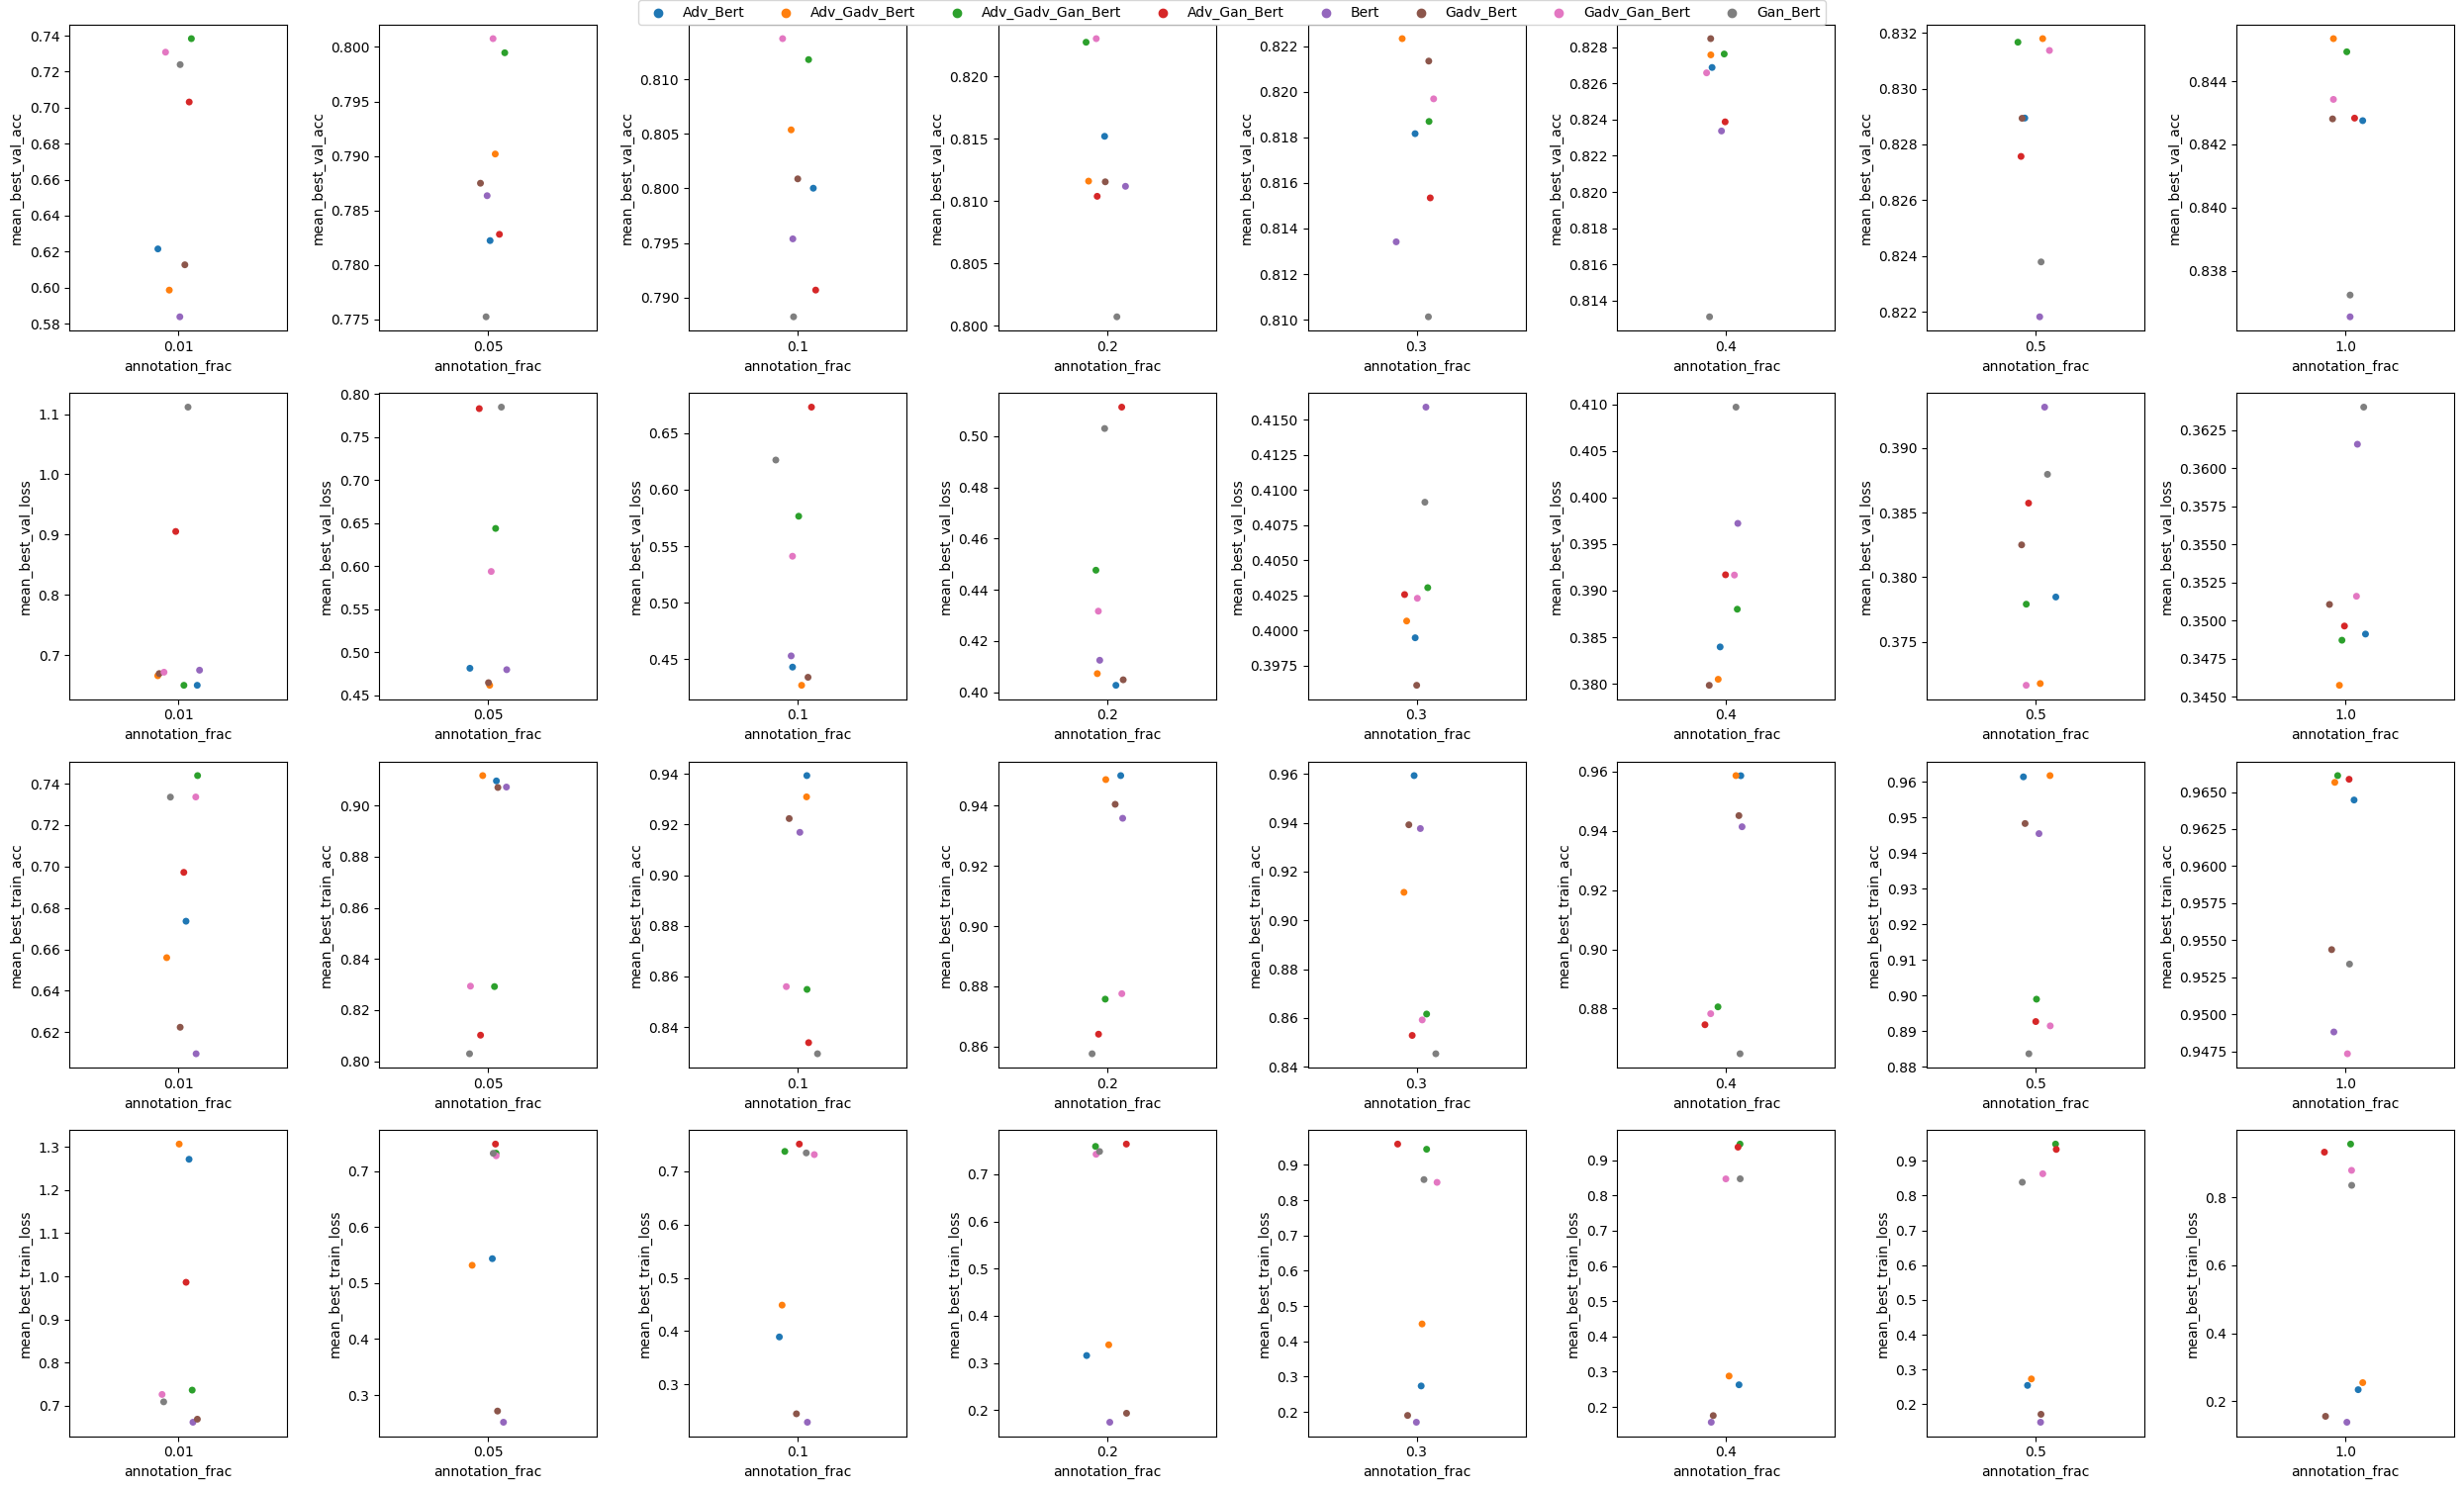

In [ ]:
#read the saved dataframe
results = pd.read_pickle(f"{RESULTS_DIR}/experiment_results.pkl")

metrics = ["best_val_acc", "best_val_loss", "best_train_acc", "best_train_loss"]
col_names = [f"mean_{metric}" for metric in metrics]

#get mean results across 5 runs for each model and format
aggregated_results = results.groupby(by=["annotation_frac","name"])[metrics].mean().reset_index()
aggregated_results = aggregated_results.rename(dict(zip(metrics,col_names)),axis=1)
aggregated_results = aggregated_results.sort_values(by=["annotation_frac","name"])

annotation_frac = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

fig, axs = plt.subplots(nrows=len(col_names), ncols=len(annotation_frac), figsize=(25,15))

#plot grid
for i, col in enumerate(col_names):
    for j, frac in enumerate(annotation_frac):
        sns.stripplot(x="annotation_frac",
                      y=col,
                      hue="name",
                      data=aggregated_results[aggregated_results["annotation_frac"]==frac],
                      ax=axs[i,j],
                      legend=True)
        axs[i,j].get_legend().remove() #we want the legend informaiton but not visualiztion

#plotting one legend for all the graphs
handles, labels = axs[i,j].get_legend_handles_labels()
fig.tight_layout()
fig.legend(handles, labels, loc='upper center', ncol=len(annotation_frac), borderaxespad=0)

In [ ]:
#read saved results
results = pd.read_pickle(f"{RESULTS_DIR}/experiment_results.pkl")

metrics = ["best_val_acc", "best_val_loss", "best_train_acc", "best_train_loss"]
col_names = [f"mean_{metric}" for metric in metrics]

#get mean values across 5 runs for each model
aggregated_results = results.groupby(by=["annotation_frac","name"])[metrics].mean().reset_index()
aggregated_results = aggregated_results.rename(dict(zip(metrics,col_names)),axis=1)
aggregated_results = aggregated_results.sort_values(by=["annotation_frac","name"])

annotation_frac = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

#print a table of the validation accuracies
for frac in annotation_frac:
    print("-"*20+f"Aggregated validation accuracy results for {frac*100}% of IMDB dataset"+"-"*20)
    print("\n")
    print(aggregated_results[aggregated_results["annotation_frac"]==frac][["name","mean_best_val_acc"]].sort_values("mean_best_val_acc", ascending=False).reset_index(drop=True))
    print("\n" *2)

--------------------Aggregated validation accuracy results for 1.0% of IMDB dataset--------------------


                name  mean_best_val_acc
0  Adv_Gadv_Gan_Bert           0.738376
1      Gadv_Gan_Bert           0.730856
2           Gan_Bert           0.723944
3       Adv_Gan_Bert           0.703152
4           Adv_Bert           0.621480
5          Gadv_Bert           0.612656
6      Adv_Gadv_Bert           0.598584
7               Bert           0.583744



--------------------Aggregated validation accuracy results for 5.0% of IMDB dataset--------------------


                name  mean_best_val_acc
0      Gadv_Gan_Bert           0.800760
1  Adv_Gadv_Gan_Bert           0.799464
2      Adv_Gadv_Bert           0.790176
3          Gadv_Bert           0.787496
4               Bert           0.786352
5       Adv_Gan_Bert           0.782808
6           Adv_Bert           0.782232
7           Gan_Bert           0.775240



--------------------Aggregated validation accuracy results for